# Trying to improve my toy model using the NAO index

In [31]:
import dask

import cftime

import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from src import utils, plot, stats, ar_model

dask.config.set(**{"array.slicing.split_large_chunks": False})

In [2]:
DATA_DIR = "../../data/processed"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12

## Prepare some boreal winter (December to March) NAO indices

In [96]:
HadGEM3 = xr.open_zarr(f"{DATA_DIR}/psl_Amon_HadGEM3-GC31-MM_dcpp.zarr")
NAO_HadGEM3 = utils.calculate_winter_nao_index(HadGEM3, [12,1,2,3])

In [ ]:
ecEarth3 = xr.open_zarr(f"{DATA_DIR}/psl_Amon_EC_Earth3_dcpp.zarr")
NAO_ecEarth3 = utils.calculate_winter_nao_index(ecEarth3, [12,1,2,3])

In [93]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/HadSLP2r.zarr")
NAO_HadSLP = utils.calculate_winter_nao_index(HadSLP, [12,1,2,3])

## Load some data

In [161]:
HadSLP = xr.open_dataset(f"{DATA_DIR}/slp.mnmean.real.nc", use_cftime=True)[["slp"]]
HadSLP = HadSLP.assign_coords({"area": gridarea_cdo(HadSLP)})
winter = HadSLP.time.dt.month.isin([1, 2, 3, 12]).sel(time=slice("1850-12-01", None))
HadSLP_winter = (
    HadSLP.where(winter, drop=True)
    .coarsen(time=4, boundary="trim", coord_func="max")
    .mean("time")
)

HadGEM3 = (
    xr.open_zarr(f"{DATA_DIR}/HadGEM3.annual.anom_1985-2014.slp_global.zarr") / 100
)

ECEarth3 = (
    xr.open_zarr(f"{DATA_DIR}/EC_Earth3.annual.anom_1985-2014.slp_global.zarr") / 100
)

## Calculate the boreal winter (December to March) NAO index

To do:
- Check what your forecasts look like relative to real forecasts
- Try fitting to hindcast winter NAO index
- Trend in one signal and trend in both signals

(-14610.0, 7305.0)

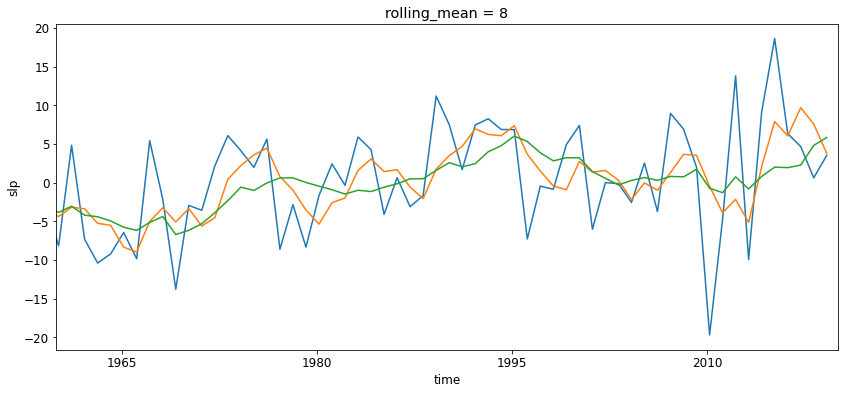

In [174]:
NAO_HadSLP = utils.get_observation_rolling_mean(
    utils.calculate_NAO_index(HadSLP_winter["slp"]), [1, 4, 8]
)
NAO_HadSLP.sel(rolling_mean=1).plot()
NAO_HadSLP.sel(rolling_mean=4).plot()
NAO_HadSLP.sel(rolling_mean=8).plot()
plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2020, 1, 1))

In [130]:
NAO_HadSLP = utils.get_observation_rolling_mean(
    utils.calculate_NAO_index(HadSLP["slp"]), [1, 4, 8]
).compute()

NAO_HadGEM3 = utils.calculate_NAO_index(
    utils.get_hindcast_mean(HadGEM3["slp"], [(0, 1), (0, 4), (0, 8)])
).compute()

NAO_ECEarth3 = utils.calculate_NAO_index(
    utils.get_hindcast_mean(ECEarth3["slp"], [(0, 1), (0, 4), (0, 8)])
).compute()

/datasets/work/oa-dcfp/work/squ027/.conda/envs/squire_2022_correlation/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(-14610.0, 3653.0)

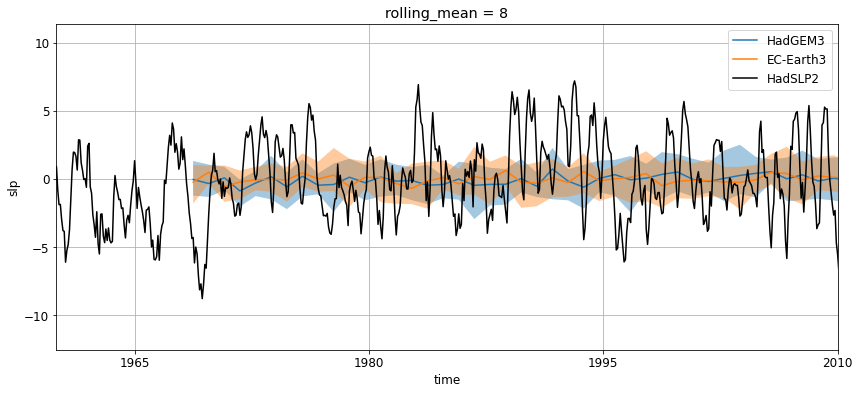

In [131]:
plt.fill_between(
    NAO_HadGEM3.time.values,
    NAO_HadGEM3.sel(rolling_mean=8).quantile(0.05, dim="member"),
    NAO_HadGEM3.sel(rolling_mean=8).quantile(0.95, dim="member"),
    color="C0",
    edgecolor="none",
    alpha=0.4,
)

plt.fill_between(
    NAO_ECEarth3.time.values,
    NAO_ECEarth3.sel(rolling_mean=8).quantile(0.05, dim="member"),
    NAO_ECEarth3.sel(rolling_mean=8).quantile(0.95, dim="member"),
    color="C1",
    edgecolor="none",
    alpha=0.4,
)

NAO_HadGEM3.sel(rolling_mean=8).mean("member").plot(color="C0", label="HadGEM3")
NAO_ECEarth3.sel(rolling_mean=8).mean("member").plot(color="C1", label="EC-Earth3")
NAO_HadSLP.sel(rolling_mean=8).plot(color="k", label="HadSLP2")

plt.grid()
plt.legend()
plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2010, 1, 1))

In [186]:
N_time = 55
N_samples = 10
N_members = 169
rolling_means = [4, 8]

In [201]:
ar_model.fit(
    input_data,
    order="select_order",
    select_order_kwargs={"maxlag": 10, "ic": "aic", "glob": True, "trend": "n"},
)

<xarray.DataArray 'slp' (params: 2)>
array([0.11929981, 5.98992485])
Coordinates:
    rolling_mean  int64 1
  * params        (params) <U7 'phi_1' 'sigma_e'
    order         int64 1

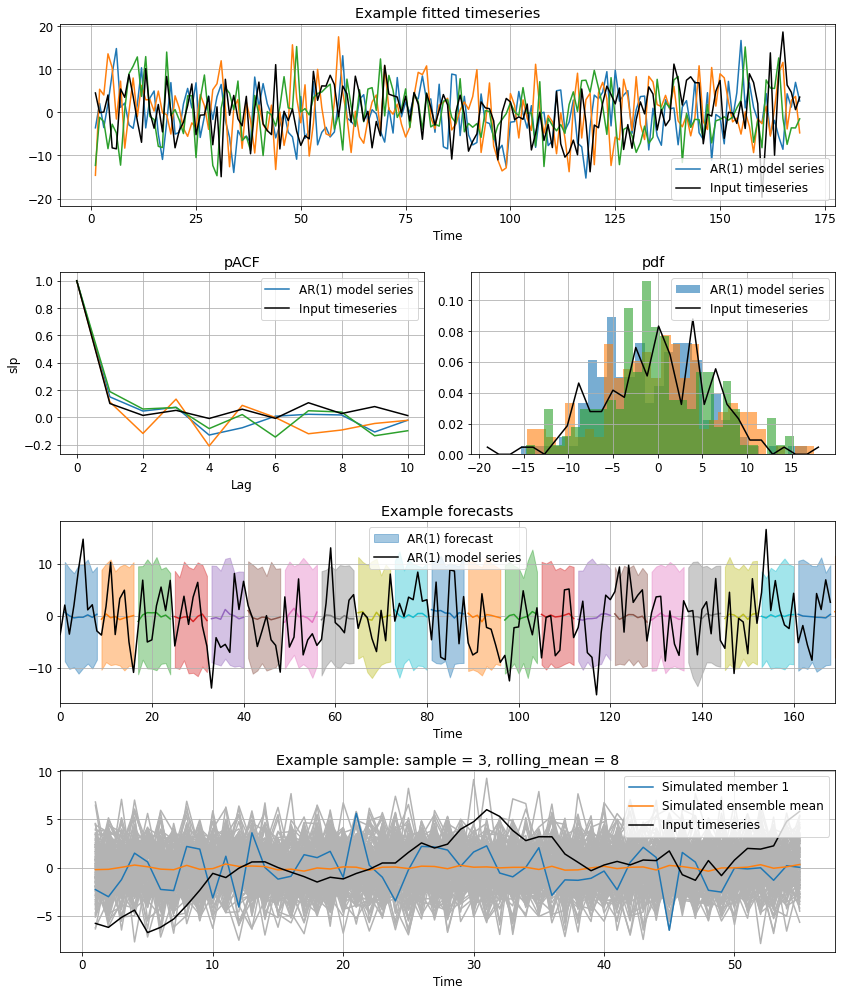

In [198]:
input_data = NAO_HadSLP.sel(rolling_mean=1).dropna("time")

fcst = ar_model.generate_samples_like(
    input_data,
    order=1,  # "select_order",
    n_times=N_time,
    n_samples=N_samples,
    n_members=N_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

obsv = ar_model.generate_samples_like(
    input_data,
    order=1,  # "select_order",
    n_times=N_time,
    n_samples=N_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)